### Inclusion and Exclusion of Recorded Neurons Based on their Firing Patterns

In the raphe, we would expect to see neuorns firing slowly and regularly. The lack of neurons firing in this manner is one indication that the location of the electrode was not in the correct regions. 

In this notebook, we perform some exploratory data analaysis. The aim is to assert that slow regular neurons were present on all  recording days. If this is not the case, 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
plt.style.use('ggplot')

In [6]:
path_to_data = r'E:\SERT_DREADD\csvs'
files = glob(os.path.join(path_to_data, '*.csv'))
df = pd.read_csv(files[0])

#### Below is the file we will use.

This file was created by the scripts in mua_preprocessing. Each row is a recorded neuron. Each column is an attribute of that neuron. 

SW_return refers to the spike width of the neuron as measured by the initial peak shoulder to the initial return to baseline amplitude (preceding the second peak) 

In [56]:
df.index.name = 'neuron_id'
print('Path to file: {}'.format(files[0]))
df.head()  # original data

Path to file: E:\SERT_DREADD\csvs\neuron_stats.csv


,spike_cluster,CV ISI,Firing Rate,recording,SW_peak,SW_return,SW_troff,base_min_amp,min_max_amp,spike_type,category
neuron_id,,,,,,,,,,,
0,435,1.089054,0.605134,2018-04-10_391b,NaN,0.800000,0.266667,611.518420,NaN,down_up,slow regular
1,444,1.914232,0.211107,2018-04-10_391b,NaN,NaN,NaN,NaN,NaN,up_down_up,slow regular
2,456,0.937104,0.068662,2018-04-10_391b,NaN,NaN,NaN,NaN,NaN,up_down_up,slow regular
3,457,0.465151,16.016615,2018-04-10_391b,NaN,0.566667,0.333333,474.025089,NaN,down_up,fast regular
4,459,2.235703,3.146396,2018-04-10_391b,NaN,0.300000,0.200000,543.436868,NaN,down_up,slow regular


#### We will use a modified versuin of the file, containing only the columns in which we are interested

In [13]:
df1 = df[['Firing Rate', 'CV ISI', 'SW_return','recording']]
df1.head()  # working dataframe

,Firing Rate,CV ISI,SW_return,recording
neuron_id,,,,
0,0.605134,1.089054,0.800000,2018-04-10_391b
1,0.211107,1.914232,NaN,2018-04-10_391b
2,0.068662,0.937104,NaN,2018-04-10_391b
3,16.016615,0.465151,0.566667,2018-04-10_391b
4,3.146396,2.235703,0.300000,2018-04-10_391b


### Overview: pairplot

Below is a 'pairplot'. The distrobution of each of the variables is shown on the diagonal. Representations of the relationship between the variables are shown by the scatter plots.

Note: the x and y axis are shared for rows and columns, respectively.

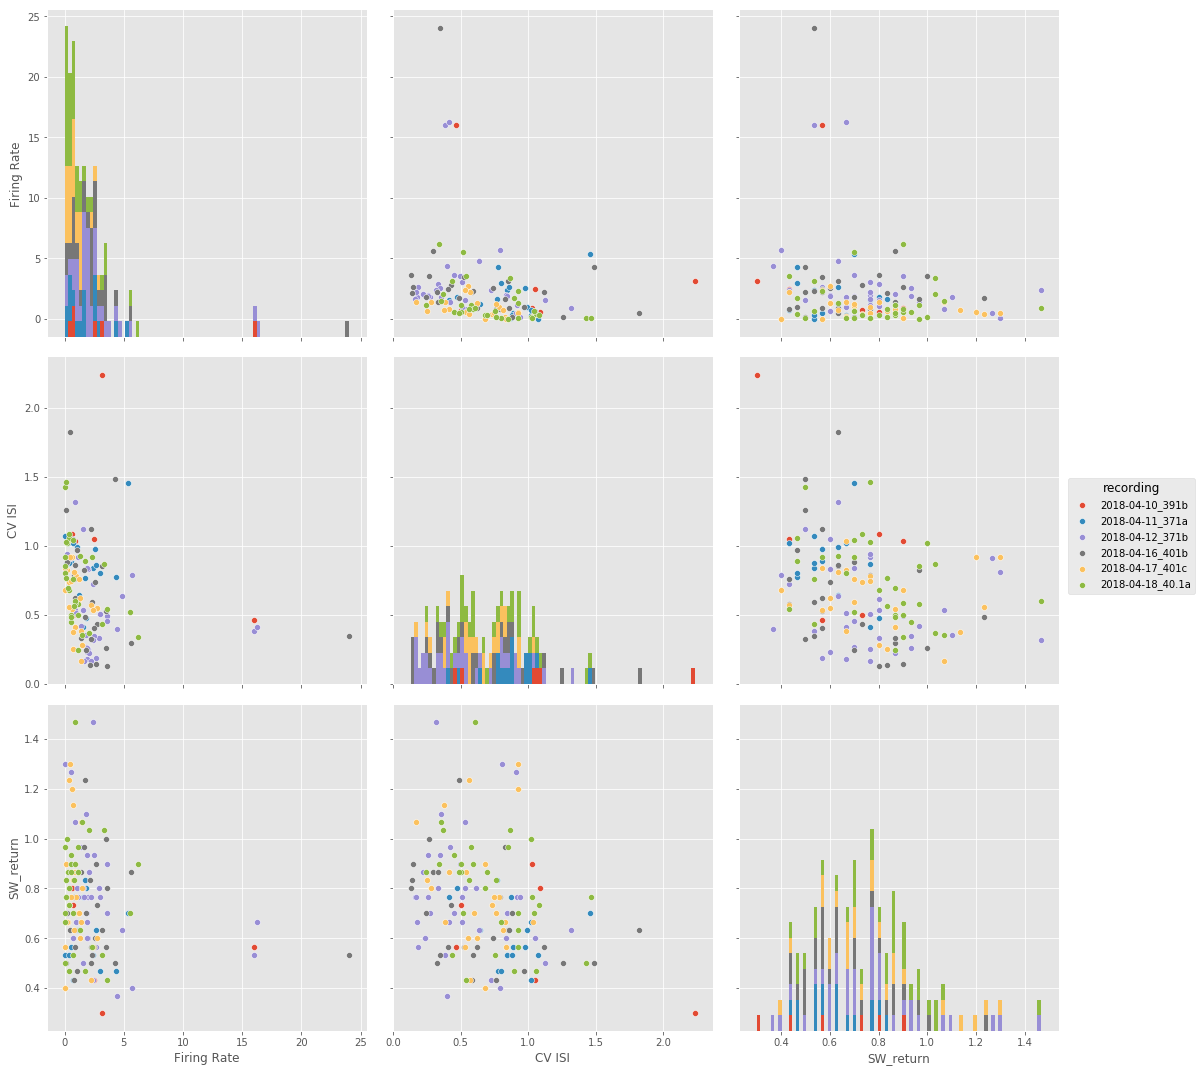

In [66]:
sns.pairplot(df1.dropna(), size=5, hue='recording', diag_kws=dict(bins=80))

The above plot shows that we do indeed have many neurons are slow (Low Mean Firing Rate) and regular (low CV ISI). There are some other interesting trends in this data, but before we jump to conclusions, lets first test the quality of the data.

### Excluding  data: CV ISI and Firing rate scatters

One way we can be confident that we were recording in the DRN is by checking for the presence of slow regular neurons. Lets categorise all neurons based on their firing rate, then separate out the data into individual recording days. If we see slow regular neurons, we know we're in the DRN. If not, we can think about excluding the data

In [42]:
def neuron_category_mapper(row):
    '''
    This is the function we use to categorise neurons as either slow or fast, and as either regular or irregular
    It categorises neurons firing slower than 4.5 Hz as slow and neurons with a CV ISI of less than 0.55 as regular
    '''
    if row['Firing Rate'] <= 4.5:
        rate = 'slow'
    else:
        rate = 'fast'
    if row['CV ISI'] <= 0.55:
        reg = 'regular'
    else:
        reg = 'irregular'
    return ' '.join([rate, reg])

In [43]:
df1['category'] = df1.apply(neuron_category_mapper, axis=1)

C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


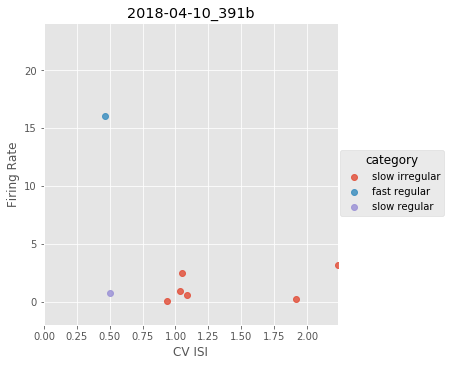

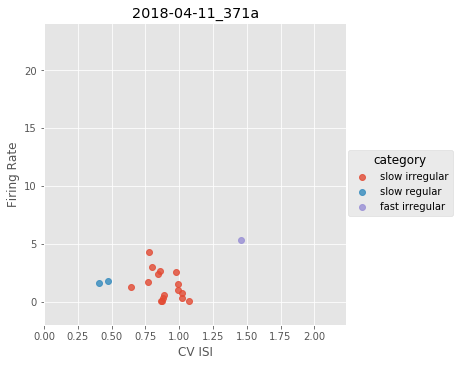

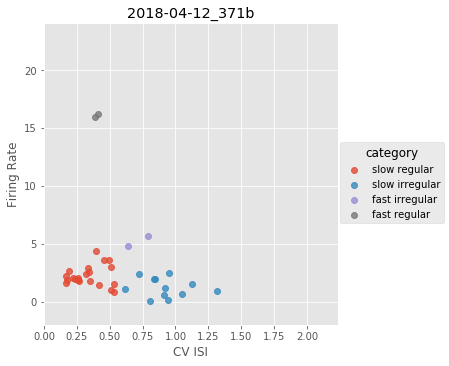

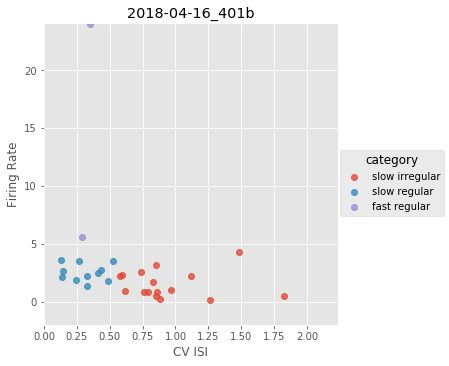

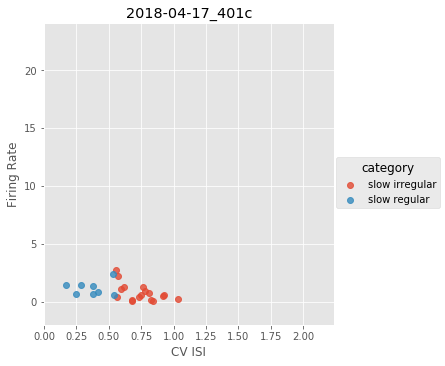

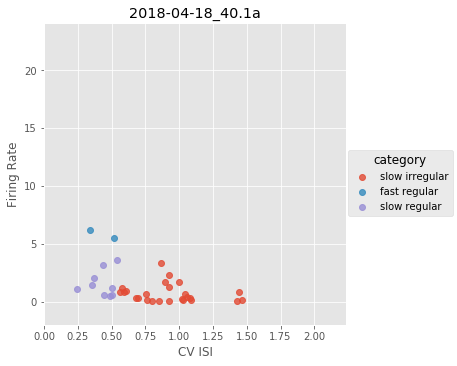

In [55]:
for i, (groupname, group) in enumerate(df1.groupby('recording')):
    sns.lmplot(x="CV ISI", y="Firing Rate", hue='category', data=group, fit_reg=False)
    ax = plt.gca()
    ax.set_title(groupname)
    ax.set_xlim([0, df1['CV ISI'].max()])
    ax.set_ylim([-2, df1['Firing Rate'].max()])

Looks like we might want to exclude data from the first two animals!

Also interesting: The regularity of neurons appears more of a coninuum rather than an obvious cluster of clocklike neurons

### Excluding Data: Drop suspicious recordings

In [63]:
recordings_to_drop = ['2018-04-10_391b', '2018-04-11_371a']
df_drop = df[~df['recording'].isin(recordings_to_drop)]  # ~ acts like 'not'

print('Remaining recordings: {}'.format(df_drop.recording.unique()))
df_drop.head()

Remaining recordings: ['2018-04-12_371b' '2018-04-16_401b' '2018-04-17_401c' '2018-04-18_40.1a']


,spike_cluster,CV ISI,Firing Rate,recording,SW_peak,SW_return,SW_troff,base_min_amp,min_max_amp,spike_type,category
neuron_id,,,,,,,,,,,
27,0,0.336092,2.891085,2018-04-12_371b,NaN,0.800000,0.300000,361.305867,NaN,down_up,slow regular
28,2,0.725420,2.420685,2018-04-12_371b,0.033333,0.433333,0.266667,188.702909,207.758182,up_down_up,slow regular
29,11,0.344218,2.527903,2018-04-12_371b,NaN,0.933333,0.633333,263.986704,NaN,down_up,slow regular
30,12,0.834113,1.969805,2018-04-12_371b,0.100000,0.600000,0.333333,272.994964,358.133273,up_down_up,slow regular
31,16,0.535195,1.563504,2018-04-12_371b,NaN,0.800000,0.266667,625.251293,NaN,down_up,slow regular


### Replot Data without Suspicious Recording Days

Now that have excluded some data, lets look at how the data distrobutions differ

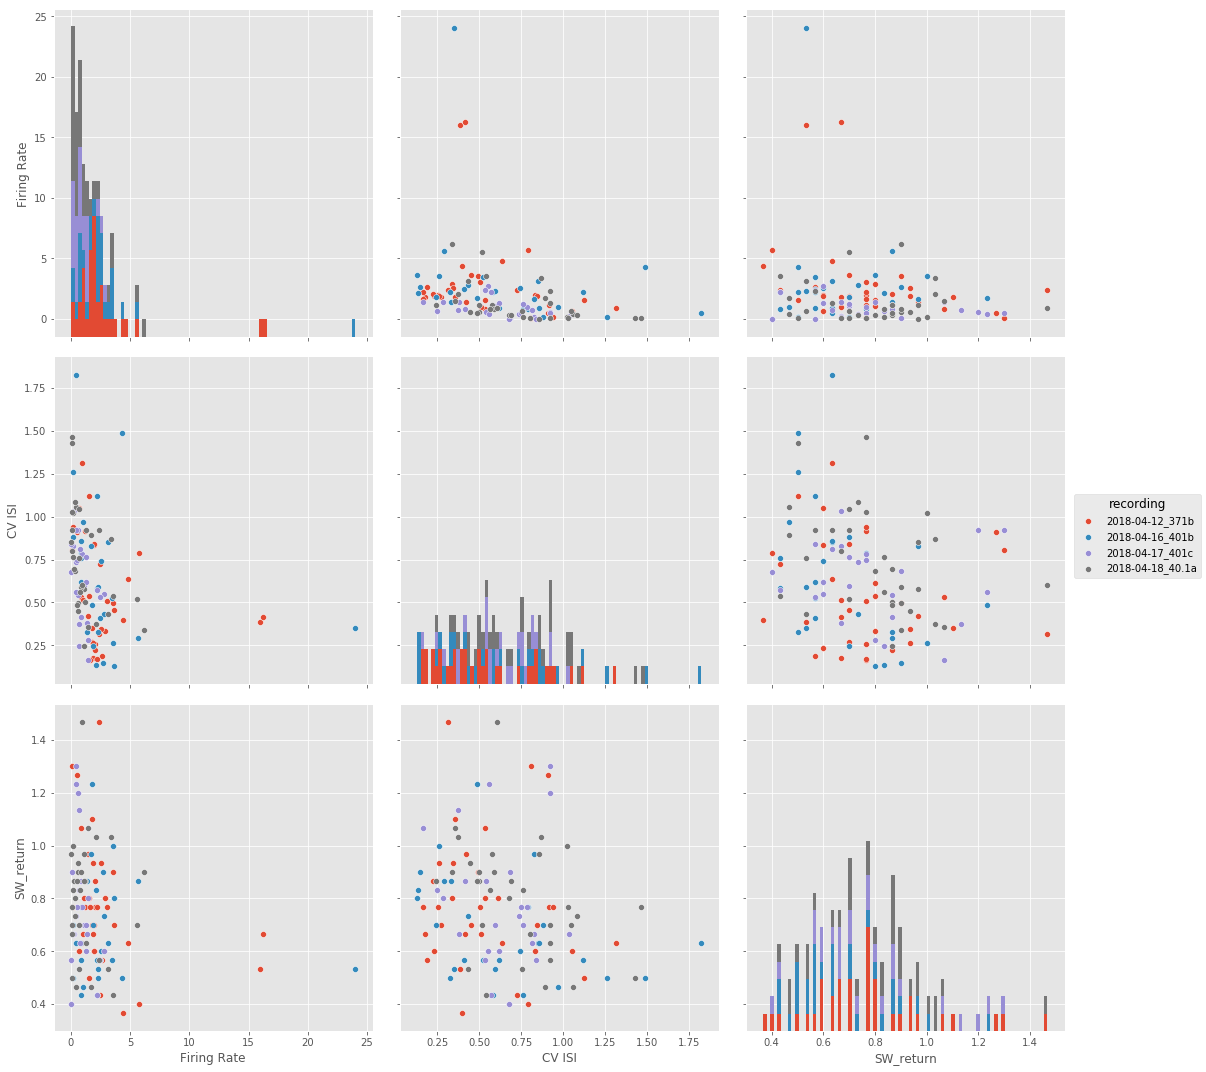

In [65]:
sns.pairplot(df_drop[['Firing Rate', 'CV ISI', 'SW_return','recording']].dropna(),
             size=5, hue='recording', diag_kws=dict(bins=80))

### Save the Dropped Data

In [67]:
path_to_out_dir = r'E:\SERT_DREADD\csvs'
filename='neuron_stats_dropped.csv'

df_drop.to_csv(os.path.join(path_to_out_dir, filename))